In [1]:
import cov_3X2
import lsst_utils
from cov_3X2 import *
from lsst_utils import *
from scipy.stats import norm,mode,skew,kurtosis,percentileofscore
import seaborn as sns
colors=sns.color_palette()
import importlib
import matplotlib.pyplot as plt
import window_utils
importlib.reload(window_utils)
from window_utils import *
import tracer_utils
from tracer_utils import *
import treecorr
from wigner_transform import *
import time
import seaborn as sns
from matplotlib.colors import LogNorm, SymLogNorm
import pickle

%matplotlib inline
%config InlineBackend.figure_formats = ['png']

In [2]:
import lsst_utils
import cov_3X2
import tracer_utils
import window_utils
import cov_utils
import importlib
reload=importlib.reload
reload(lsst_utils)
reload(window_utils)
reload(cov_utils)
reload(tracer_utils)
reload(cov_3X2)
from lsst_utils import *
from cov_utils import *
from cov_3X2 import *

In [2]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.ERROR)

In [3]:
class DeltaTimer:
    def __init__(self):
        self.ti =  time.time()
        self.tf =  0.
        self.d  =  0.
        
    def __call__(self, msg):
        self.tf= time.time()
        self.d = self.tf-self.ti
        self.ti=self.tf
        print(self.d, msg)

In [4]:
from distributed import LocalCluster
from dask.distributed import Client
#http://distributed.readthedocs.io/en/latest/_modules/distributed/worker.html
LC=LocalCluster(n_workers=16,processes=False,memory_limit='120gb',threads_per_worker=1,
                local_dir='/home/chienhal/jh/tmp/NGL-worker',
               )#memory_spill_fraction=.99,
#                memory_monitor_interval='2000ms')
client=Client(LC,diagnostics_port=7878)

/home/chienhal/anaconda3/lib/python3.6/site-packages/distributed/dashboard/core.py:74: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [5]:
client

Client Scheduler: inproc://10.1.2.251/12968/1 Dashboard: http://localhost:36922/status,Cluster Workers: 16 Cores: 16 Memory: 1.92 TB


In [7]:
#setup parameters
lmax_cl=4000
lmin_cl=0
l0=np.arange(lmin_cl,lmax_cl)
lmin_cl_Bins=lmin_cl+10
lmax_cl_Bins=lmax_cl-10
Nl_bins=40
l_bins=np.int64(np.logspace(np.log10(lmin_cl_Bins),np.log10(lmax_cl_Bins),Nl_bins))
# l_bins=np.int64(np.linspace(lmin_cl_Bins,lmax_cl_Bins,Nl_bins))
lb=(l_bins[1:]+l_bins[:-1])*.5  ##bin centers
l=l0 #np.unique(np.int64(np.logspace(np.log10(lmin_cl),np.log10(lmax_cl),Nl_bins*20))) #if we want to use fewer ell

do_cov=False
bin_cl=True
SSV_cov=True
tidal_SSV_cov=False
do_xi=True
bin_xi=True

use_window=True
store_win=True

f_sky=0.3
n_source_bins=1 ## 1 z-bins
sigma_gamma=0.3944/np.sqrt(2.)  #*2**0.25
nside=1024

corr_ggl=('galaxy','kappa')
corr_gg=('galaxy','galaxy')
corr_kk=('kappa','kappa') #or kappa 
corrs = [corr_kk, corr_ggl, corr_gg]

corrs_shear = [('shear','shear'), ('galaxy','shear'), ('galaxy','galaxy')]

In [10]:
#this is a multiplicative factor, used to compute the complicated window below.
l0w=np.arange(512)+1
mean=150
sigma=50
ww=1000*np.exp(-(l0w-mean)**2/sigma**2)
x=ww<1
ww[x]=1
# x=l0w>mean+3*sigma
# ww[x]=ww[l0w==mean+3*sigma]

In [11]:
z0=0.5
zl_bin1=lsst_source_tomo_bins(zp=np.array([z0]),p_zp=np.array([1]),ns=10,use_window=use_window,nbins=1,window_cl_fact=1,
                         f_sky=f_sky,nside=nside,unit_win=False,use_shot_noise=True) #this creates a more realistic window, with power spectra similar to galaxy power spectra
zl_bin_unit=lsst_source_tomo_bins(zp=np.array([z0]),p_zp=np.array([1]),ns=10,use_window=use_window,nbins=1,window_cl_fact=0,
                         f_sky=f_sky,nside=nside,unit_win=True,use_shot_noise=True) #this creates a unit window ( zero or 1)

z0=1
zs_bin1=lsst_source_tomo_bins(zp=np.array([z0]),p_zp=np.array([1]),ns=30,use_window=use_window,nbins=1,window_cl_fact=1,
                         f_sky=f_sky,nside=nside,unit_win=False,use_shot_noise=True) #this creates a more realistic window, with power spectra similar to galaxy power spectra
zs_bin_unit=lsst_source_tomo_bins(zp=np.array([z0]),p_zp=np.array([1]),ns=30,use_window=use_window,nbins=1,window_cl_fact=0,
                         f_sky=f_sky,nside=nside,unit_win=True,use_shot_noise=True)  #this creates a unit window ( zero or 1)

ns0:  27.0
corr_indxs {('shear', 'shear'): [], ('galaxy', 'galaxy'): [(0, 0)], ('kappa', 'kappa'): []}


./cov_utils.py:60: RuntimeWarning: invalid value encountered in true_divide
  Win0=2*jn(1,l_th)/l_th
./angular_power_spectra.py:23: RuntimeWarning: divide by zero encountered in true_divide
  self.cl_f=(l+0.5)**2/(l*(l+1.)) # cl correction from Kilbinger+ 2017
/home/chienhal/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:466: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


cl dict done


/home/chienhal/anaconda3/lib/python3.6/site-packages/healpy/sphtfunc.py:400: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning,


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
ns0:  27.0
corr_indxs {('shear', 'shear'): [], ('galaxy', 'galaxy'): [(0, 0)], ('kappa', 'kappa'): []}
cl dict done
ns0:  27.000000000000004
corr_indxs {('shear', 'shear'): [], ('galaxy', 'galaxy'): [(0, 0)], ('kappa', 'kappa'): []}
cl dict done
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
ns0:  27.000000000000004
corr_indxs {('shear', 'shear'): [], ('galaxy', 'galaxy'): [(0, 0)], ('kappa', 'kappa'): []}
cl dict done


In [10]:
# zl_bin=lsst_source_tomo_bins(ns=10,use_window=use_window,nbins=n_source_bins,
#                          f_sky=f_sky,nside=nside,unit_win=True)

# zs_bin=lsst_source_tomo_bins(ns=30,use_window=use_window,
#                               f_sky=f_sky,nbins=n_source_bins,nside=nside,unit_win=True)


ns0:  27.0
ns0:  27.0


In [12]:
print(zs_bin1)

{'SN': {'galaxy': array([[[2.78166788e-07]]]), 'shear': array([[[1.88040749e-08]]]), 'kappa': array([[[1.88040749e-08]]])}, 0: {'z': array([0.        , 0.0201005 , 0.04020101, 0.06030151, 0.08040201,
       0.10050251, 0.12060302, 0.14070352, 0.16080402, 0.18090452,
       0.20100503, 0.22110553, 0.24120603, 0.26130653, 0.28140704,
       0.30150754, 0.32160804, 0.34170854, 0.36180905, 0.38190955,
       0.40201005, 0.42211055, 0.44221106, 0.46231156, 0.48241206,
       0.50251256, 0.52261307, 0.54271357, 0.56281407, 0.58291457,
       0.60301508, 0.62311558, 0.64321608, 0.66331658, 0.68341709,
       0.70351759, 0.72361809, 0.74371859, 0.7638191 , 0.7839196 ,
       0.8040201 , 0.8241206 , 0.84422111, 0.86432161, 0.88442211,
       0.90452261, 0.92462312, 0.94472362, 0.96482412, 0.98492462,
       1.00502513, 1.02512563, 1.04522613, 1.06532663, 1.08542714,
       1.10552764, 1.12562814, 1.14572864, 1.16582915, 1.18592965,
       1.20603015, 1.22613065, 1.24623116, 1.26633166, 1.286432

In [24]:
print(zs_bin['SN'])

{'galaxy': array([[[3.13392407e-09]]]), 'shear': array([[[2.11853267e-10]]]), 'kappa': array([[[2.11853267e-10]]])}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


In [13]:
th_min=1./60
th_max=600./60
n_th_bins=20
th_bins=np.logspace(np.log10(th_min),np.log10(th_max),n_th_bins+1)
th=np.logspace(np.log10(th_min*0.98),np.log10(1),n_th_bins*30)
th2=np.linspace(1,th_max*1.02,n_th_bins*30)
th=np.unique(np.sort(np.append(th,th2)))
thb=np.sqrt(th_bins[1:]*th_bins[:-1])

l0_win=np.arange(lmax_cl)
WT_L_kwargs={'l': l0_win,'theta': th*d2r,'m1_m2':[(2,2),(2,-2),(0,2),(2,0),(0,0)]}
%time WT_L=wigner_transform(**WT_L_kwargs)


./wigner_functions.py:38: RuntimeWarning: invalid value encountered in true_divide
  d_mat/=np.sqrt(binom(k+b,b))
./wigner_functions.py:38: RuntimeWarning: divide by zero encountered in true_divide
  d_mat/=np.sqrt(binom(k+b,b))
./wigner_functions.py:38: RuntimeWarning: divide by zero encountered in true_divide
  d_mat/=np.sqrt(binom(k+b,b))


CPU times: user 4.7 s, sys: 2.28 s, total: 6.98 s
Wall time: 44.1 s


In [15]:
wigner_files={}
wigner_files[0]= '/home/chienhal/jh/sklens_wig3j/skylens_wig3j/dask_wig3j_l5000_w500_0_asym50.zarr'
wigner_files[2]= '/home/chienhal/jh/sklens_wig3j/skylens_wig3j/dask_wig3j_l5000_w500_2_asym50.zarr'

In [16]:
#use realistic window
kappa_win=cov_3X2(zk_bins=zs_bin1,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,l=l0, zg_bins=zl_bin1,
            use_window=use_window,store_win=store_win,window_lmax=400,corrs=corrs,
            SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV_cov,f_sky=f_sky,
            HT=WT_L,bin_xi=bin_xi,theta_bins=th_bins,do_xi=do_xi,wigner_files=wigner_files)

corr_indxs {('shear', 'shear'): [], ('galaxy', 'galaxy'): [(0, 0)], ('kappa', 'kappa'): [], ('galaxy', 'kappa'): [(0, 0)], ('kappa', 'galaxy'): [(0, 0)]}
Win gen: step size 140
wigner_files: {0: '/home/chienhal/jh/sklens_wig3j/skylens_wig3j/dask_wig3j_l5000_w500_0_asym50.zarr', 2: '/home/chienhal/jh/sklens_wig3j/skylens_wig3j/dask_wig3j_l5000_w500_2_asym50.zarr'}
wigner done dict_keys([0, 2])
setting windows <Client: scheduler='inproc://10.1.2.251/12968/1' processes=16 cores=16>
got window cls, now to coupling matrices.
done coupling submatrix  0 99.35198783874512 2.4919121265411377 96.86007475852966
done coupling submatrix  140 48.15101146697998 2.4358890056610107 45.715120792388916
done coupling submatrix  280 54.45785927772522 2.3877041339874268 52.07015371322632
done coupling submatrix  420 45.88513946533203 2.4464778900146484 43.43866014480591
done coupling submatrix  560 46.39934539794922 2.5626091957092285 43.836735248565674
done coupling submatrix  700 45.34664011001587 2.56676

In [ ]:
# print(corrs_shear)
# kappa_shear=cov_3X2(zs_bins=zs_bin,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,l=l0, zg_bins=zl_bin,
#             use_window=use_window,store_win=store_win,window_lmax=400,corrs=corrs_shear,
#             SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV_cov,f_sky=f_sky,
#             HT=WT_L,bin_xi=bin_xi,theta_bins=th_bins,do_xi=do_xi) ## used to compute shear-galaxy correlation functions

In [70]:
# kappa_shear.z_bins.keys()

dict_keys(['shear', 'galaxy'])

In [ ]:
# %time clG_win=kappa_win.cl_tomo(corrs=corrs) 
# %time cl0_win=clG_win['stack'].compute() #stack?

# if do_xi:
#     %time xiWG_L=kappa_win.xi_tomo()
#     %time xiW_L=xiWG_L['stack'].compute()

In [17]:
clG0=kappa_win.cl_tomo() 
cl0 = (clG0['cl'][corr_kk][(0,0)].compute(), clG0['cl'][corr_ggl][(0,0)].compute(), clG0['cl'][corr_gg][(0,0)].compute())

cl dict done


KeyError: (0, 0)

In [ ]:
# xiG = kappa_shear.xi_tomo()
# xi = xiG['stack'].compute()

In [ ]:
# print(xiG['xi'])
# print(kappa_shear.tracers)
# print(  dir(kappa_shear) )
# print(xi)

In [14]:
def kappa_map_gen(kappa, nside=nside, use_window=False, noise=True):
    dt = DeltaTimer()
    
    l = kappa.l
    l_bins = kappa.l_bins
    nu=2.*l+1.
    
    if use_window:
        windows = {}
        masks = {}
        seen_indices = {}
        windows_one_indices = {}

        windows[0] = kappa.z_bins['kappa'][0]['window']
        masks[0] = windows[0]==hp.UNSEEN
        seen_indices[0] = np.where( windows[0]!=hp.UNSEEN )[0]
        windows_one_indices[0] = np.where( windows[0]==1.0 )[0]

        windows[1] = kappa.z_bins['galaxy'][0]['window']
        masks[1] = windows[1]==hp.UNSEEN
        seen_indices[1] = np.where( windows[1]!=hp.UNSEEN )[0]
        windows_one_indices[1] = np.where( windows[1]==1.0 )[0]
        
    
    cl_map = hp.synfast(cl0,nside=nside,new=False,pol=False) ## kappa map + galaxy overdensity map
    
    kappa_alm, gal_alm = hp.map2alm(cl_map,pol=False, lmax=max(l)) ## generate correlated alm's from maps
    
    #########################################
    ##   Kappa and shear
    #########################################
    
    if noise:
        cl_sn_kk = kappa_win.SN[corr_kk]
        kappa_alm += hp.synalm(cl_sn_kk[:,0,0])
    
        
    trans_factor = [-np.sqrt( (li+2)*(li-1)/(li*(li+1))) for li in l   ] 
    trans_factor[0] = 0.
    trans_factor[1] = 0.
    
    gamma_alm = hp.sphtfunc.almxfl(kappa_alm, trans_factor)
    
    corr_config = {'min_sep':3., 'max_sep':400, 'nbins':20, 'sep_units':'arcmin'}
    
    k_map, g1_map, g2_map = hp.sphtfunc.alm2map( (kappa_alm,gamma_alm,kappa_alm*0 ), nside=nside,pol=True  )
    
    
    ###########################################
    ##  Galaxy
    ###########################################
    
    if noise:
        cl_sn_gg = kappa_win.SN[corr_gg]
        cl_map[1] += hp.synfast(cl_sn_gg[:,0,0])
    
    
    ###########################################
    ##  Window (apply window after noise and the conversion from kappa to shear)
    ###########################################
    if use_window:
        for i in range(2):
            cl_map[i]*=windows[i]
            cl_map[i][masks[i]] = hp.UNSEEN
    
    if use_window:
        g1_map*=window[0]
        g1_map[masks[0]] = hp.UNSEEN
        
        g2_map*=window[0]
        g2_map[masks[0]] = hp.UNSEEN
    
    
    ###################################
    ##   shear shear correlation
    ###################################
    if use_window:
        theta, phi = hp.pix2ang(nside, seen_indices[0])
    else:
        theta, phi = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)))
        
    ra = np.degrees(np.pi*2.-phi)
    dec = -np.degrees(theta-np.pi/2.)
    
    if use_window:
        g1_map = g1_map[seen_indices[0]]
        g2_map = g2_map[seen_indices[0]]
    
    cat_gg = treecorr.Catalog(ra=ra, dec=dec, g1=g1_map, g2=g2_map, ra_units='deg', dec_units='deg')
    
#     dt('cat_gg')
    
    gg = treecorr.GGCorrelation(**corr_config)
    gg.process(cat_gg)
    
#     dt('corr_gg')
    

    
    #######################################
    ##  galaxy galaxy correlation
    #######################################
    if use_window:
        theta, phi = hp.pix2ang(nside, seen_indices[1])  ##galaxy window
    else:
        theta, phi = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)))
        
    ra = np.degrees(np.pi*2.-phi)
    dec = -np.degrees(theta-np.pi/2.)
    
    if use_window:
        k = cl_map[1][seen_indices[1]] ## map of galaxy overdensity
    else:
        k = cl_map[1]
        
    cat_kk = treecorr.Catalog(ra=ra, dec=dec, k=k, ra_units='deg', dec_units='deg')
    
    
    kk = treecorr.KKCorrelation(**corr_config)
    kk.process(cat_kk)
    
    #######################################
    ##  galaxy-galaxy lensing correlation
    #######################################
    
    kg = treecorr.KGCorrelation(**corr_config)
    kg.process(cat_kk, cat_gg)

    
    res_dict = {'r':gg.rnom, 'xip':gg.xip, 'xim':gg.xim, 'gg':kk.xi, 'ggl':kg.xi}
    return res_dict

In [15]:
%time res = kappa_map_gen(kappa_win, nside=nside, use_window=use_window, noise=False)

/home/chienhal/anaconda3/lib/python3.6/site-packages/healpy/sphtfunc.py:400: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning,


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


/home/chienhal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in long_scalars
/home/chienhal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in sqrt


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


distributed.comm.inproc - WARNING - Closing dangling queue in <InProc  local=inproc://10.1.2.244/55341/81 remote=inproc://10.1.2.244/55341/28>


CPU times: user 28min 7s, sys: 1min 13s, total: 29min 21s
Wall time: 2min 18s


In [19]:
%time res_noise = res = kappa_map_gen(kappa_win, nside=nside, use_window=use_window, noise=True)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


/home/chienhal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in long_scalars
/home/chienhal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in sqrt


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [16]:
th, w = WT_L.projected_correlation(l_cl=l, cl=cl0[0], m1_m2=(2,2))
th, wm = WT_L.projected_correlation(l_cl=l, cl=cl0[0], m1_m2=(2,-2))
th, wg = WT_L.projected_correlation(l_cl=l, cl=cl0[2], m1_m2=(0,0))
th, wggl = WT_L.projected_correlation(l_cl=l, cl=cl0[1], m1_m2=(0,2))

print(len(l))

4000


Healpix resolution with nside=1024 :  3.435486411817406 arcmin


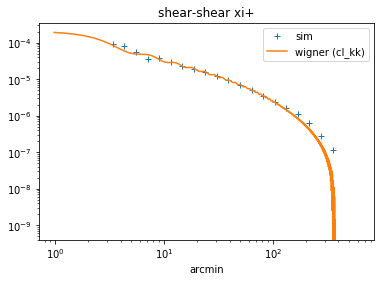

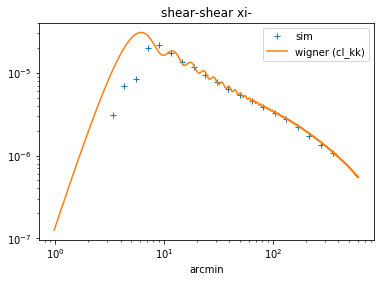

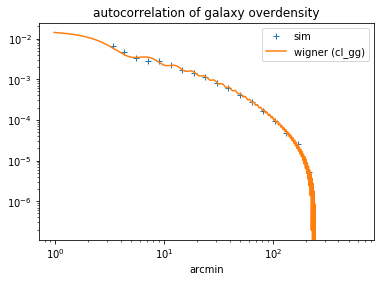

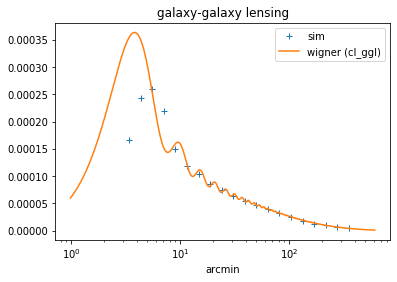

In [18]:
logger = logging.getLogger()
logger.setLevel(logging.ERROR)
print("Healpix resolution with nside={} :  {} arcmin".format(nside, hp.nside2resol(nside, arcmin = True)))

plt.plot(res['r'], res['xip'], '+', label='sim')
plt.plot(th/d2r*60., w, '-', label='wigner (cl_kk)')
plt.title('shear-shear xi+')
plt.xlabel('arcmin')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

plt.plot(res['r'], res['xim'], '+', label='sim')
plt.plot(th/d2r*60., wm, '-', label='wigner (cl_kk)')
plt.title('shear-shear xi-')
plt.xlabel('arcmin')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

plt.plot(res['r'], res['gg'], '+', label='sim')
plt.plot(th/d2r*60., wg, '-', label='wigner (cl_gg)')
plt.title('autocorrelation of galaxy overdensity')
plt.xlabel('arcmin')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

plt.plot(res['r'], res['ggl'], '+', label='sim')
plt.plot(th/d2r*60., wggl, '-', label='wigner (cl_ggl)')
plt.title('galaxy-galaxy lensing')
plt.xlabel('arcmin')
plt.xscale('log')
plt.legend()
plt.show()

Healpix resolution with nside=1024 :  3.435486411817406 arcmin


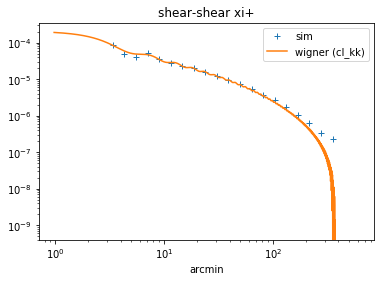

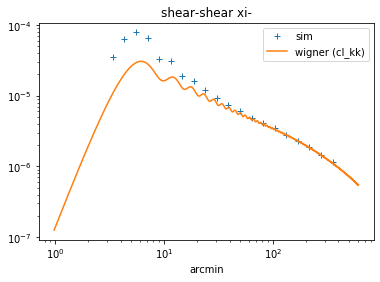

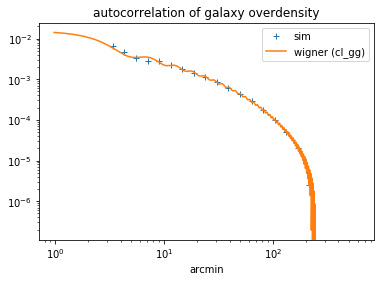

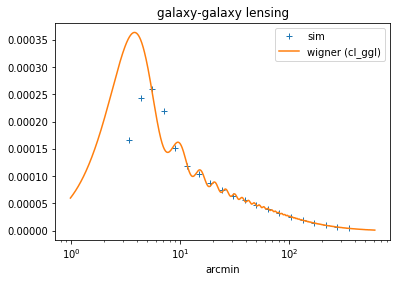

In [21]:
print("Healpix resolution with nside={} :  {} arcmin".format(nside, hp.nside2resol(nside, arcmin = True)))

plt.plot(res_noise['r'], res_noise['xip'], '+', label='sim')
plt.plot(th/d2r*60., w, '-', label='wigner (cl_kk)')
plt.title('shear-shear xi+')
plt.xlabel('arcmin')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

plt.plot(res_noise['r'], res_noise['xim'], '+', label='sim')
plt.plot(th/d2r*60., wm, '-', label='wigner (cl_kk)')
plt.title('shear-shear xi-')
plt.xlabel('arcmin')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

plt.plot(res_noise['r'], res_noise['gg'], '+', label='sim')
plt.plot(th/d2r*60., wg, '-', label='wigner (cl_gg)')
plt.title('autocorrelation of galaxy overdensity')
plt.xlabel('arcmin')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

plt.plot(res_noise['r'], res_noise['ggl'], '+', label='sim')
plt.plot(th/d2r*60., wggl, '-', label='wigner (cl_ggl)')
plt.title('galaxy-galaxy lensing')
plt.xlabel('arcmin')
plt.xscale('log')
plt.legend()
plt.show()

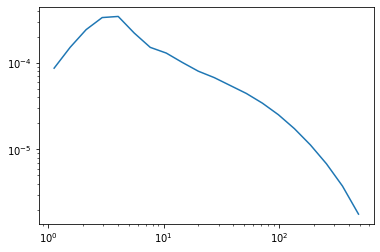

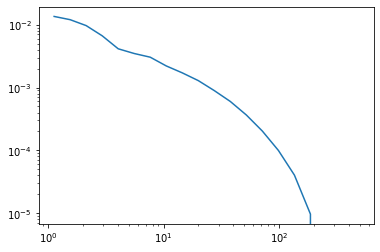

In [39]:
th_bins_nom = [np.sqrt( th_bins[i]*th_bins[i+1])/d2r for i in range(len(th_bins)-1)]
plt.plot(th_bins_nom, xi['xi'][:20])
plt.xscale('log')
plt.yscale('log')
plt.show()

plt.plot(th_bins_nom, xi['xi'][20:])
plt.xscale('log')
plt.yscale('log')
plt.show()

In [23]:
#from 8:20pm
n_sims = 100
res_list = []
for i in range(n_sims):
    print(i+1)
    res_list.append(kappa_map_gen(kappa_win, nside=nside, use_window=use_window, noise=True) )

1
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


/home/chienhal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in long_scalars
/home/chienhal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in sqrt


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
2
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
3
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
4
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
5
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
6
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
7
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
8
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000

distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


46
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
47
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


48
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
49
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


50
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
51
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
52
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


53
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
54
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


55
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
56
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


57
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
58
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
59
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


60
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
61
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


62
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
63
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


64
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
65
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
66
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


67
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
68
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


69
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
70
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


71
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
72
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
73
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


74
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
75
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


76
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
77
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


78
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
79
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
80
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


81
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
82
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


83
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
84
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


85
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
86
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
87
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


88
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
89
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


90
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
91
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


92
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
93
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
94
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


95
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
96
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


97
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
98
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


99
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
100
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


In [25]:
n_theta_bins = 20
data_vectors = np.zeros( (n_sims, n_theta_bins*4) ) ### each row represents a joint data vector
for i in range(n_sims):
    data_vectors[i,:] = np.hstack( (res_list[i]['xip'],res_list[i]['xim'],res_list[i]['ggl'], res_list[i]['gg']) )

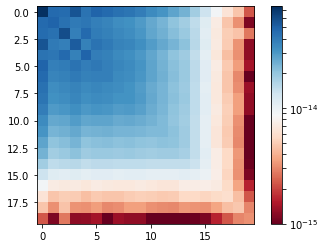

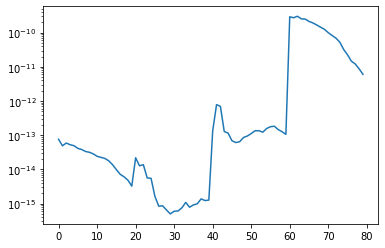

In [67]:
cov = np.cov(data_vectors.T)

mat_obj = cov[:20,:20]
plt.imshow(mat_obj, norm=SymLogNorm(vmin=mat_obj.min(), vmax=mat_obj.max(),linthresh=1.E-15, linscale=0.01),cmap='RdBu')
plt.colorbar()
plt.show()

plt.plot( np.diag(cov) )
plt.yscale('log')
plt.show()

In [73]:
### save data
dict_save = {'zs_bin':zs_bin, 'zl_bin':zl_bin, 'cl0':cl0, 'theta_bin_centers':res_list[0]['r'], 'data_vectors':data_vectors}
with open('corr_sim100.pkl', 'wb') as f:
    pickle.dump(dict_save, f)

In [76]:
with open('corr_sim100.pkl', 'rb') as f:
    dict_load = pickle.load(f)
    print(dict_load.keys())
    print(dict_load['data_vectors'])

dict_keys(['zs_bin', 'zl_bin', 'cl0', 'theta_bin_centers', 'data_vectors'])
[[ 8.53371120e-05  4.79511672e-05  4.06262243e-05 ...  1.11460008e-09
  -2.14564459e-06 -4.32376220e-06]
 [ 8.59272415e-05  4.83646977e-05  4.08176228e-05 ...  1.02139778e-05
  -4.43247224e-06 -5.63409064e-06]
 [ 8.58107914e-05  4.79047295e-05  4.06551132e-05 ... -2.11210536e-06
  -7.81703195e-06 -8.92195072e-06]
 ...
 [ 8.55491265e-05  4.81117778e-05  4.08395821e-05 ...  6.69474144e-06
  -3.27208232e-06 -4.83783044e-06]
 [ 8.60586472e-05  4.82280101e-05  4.09710214e-05 ...  5.72668385e-06
  -8.02598085e-06 -1.12376783e-05]
 [ 8.55626348e-05  4.81257486e-05  4.09238069e-05 ...  4.17241791e-06
  -9.75822610e-07 -6.97115368e-06]]


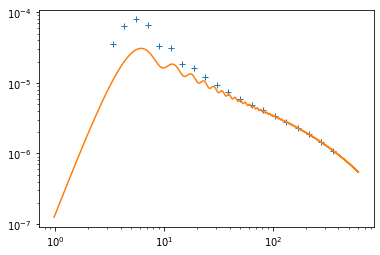

In [84]:
i_sim = 50
plt.loglog(res_list[i_sim]['r'],res_list[i_sim]['xim'], '+')
plt.plot(th/d2r*60., wm, '-')
plt.show()